In [1]:
!pip install pycocotools>=2.0.1

In [ ]:
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip annotations_trainval2017.zip
!rm annotations_trainval2017.zip
!mkdir COCOdataset2017
!mv annotations COCOdataset2017/

In [15]:
from pycocotools.coco import COCO
from tqdm import tqdm_notebook
import urllib.request
import os, cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
plt.rcParams['figure.figsize'] = (20.0, 10.0)

In [ ]:
coco = COCO('COCOdataset2017/annotations/instances_train2017.json')

In [5]:
cats=coco.loadCats(coco.getCatIds())
names=[cat['name'] for cat in cats]

In [ ]:
names

In [9]:
!mkdir -p COCOdataset2017/images/

# EDA

In [21]:
def download_images( category_names, types, image_counts):
    base_dir = 'COCOdataset2017/images/'

    for data_type in types:
      for category_name in category_names:
        catIds = coco.getCatIds(catNms=[category_name])
        imgIds = coco.getImgIds(catIds=catIds)

        imgIds = imgIds[:image_counts[data_type]]
        images = coco.loadImgs(imgIds)
        category_dir = os.path.join(base_dir, data_type, category_name)
        os.makedirs(category_dir, exist_ok=True)

        for im in tqdm(images, desc=f'Downloading {data_type} {category_name} images'):
            im_path = os.path.join(category_dir, im['file_name'])
            if not os.path.exists(im_path):
                urllib.request.urlretrieve(im['coco_url'], im_path)

In [ ]:
run this

In [22]:
categories = ['person', 'car', 'dog', 'cake']
image_counts = {'train': 300, 'valid': 300, 'test': 30}
# types=list(image_counts.keys())
types=["valid","test"]
download_images( categories, types, image_counts)

Display BBox around indentified objects

In [90]:
def display_image(im_path):
  im = cv2.imread(im_path)
  im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
  img_id = int(im_path.split('/')[-1].split('.')[0])
  catIds=coco.getCatIds(im_path.split("/")[-2])
  annIds = coco.getAnnIds(imgIds=img_id, catIds=catIds, iscrowd=None)
  anns = coco.loadAnns(annIds)
  detected_objects =[{names[annot['category_id'] -1]: annot['bbox']} for annot in anns]
  for obj in detected_objects:
    for label, bbox in obj.items():
        x, y, w, h = map(int, bbox)
        cv2.rectangle(im, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(im, label, (x, y-10), cv2.FONT_HERSHEY_DUPLEX, 1, (0, 255, 0), 5)

  plt.imshow(im)

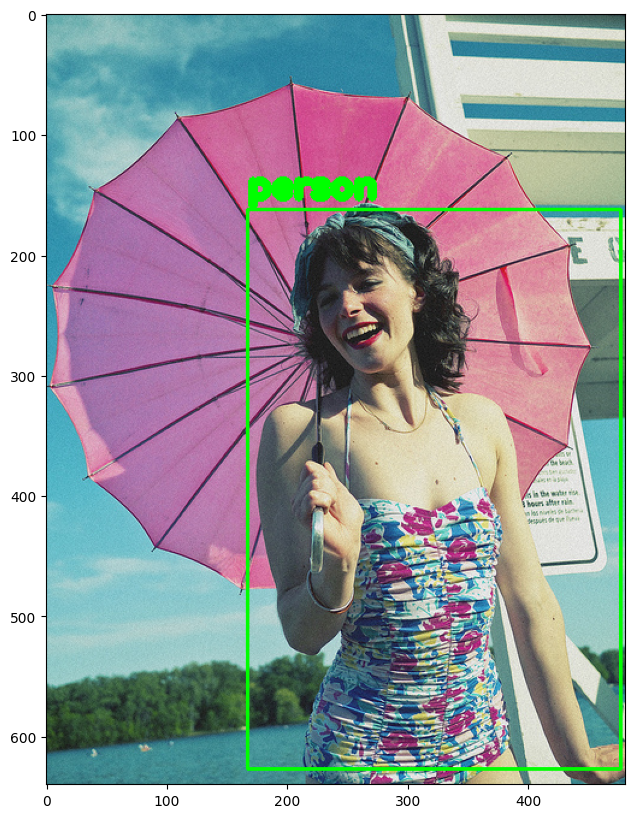

In [92]:
display_image("/content/COCOdataset2017/images/train/person/000000000036.jpg")

Display segment polygons around images

In [94]:
def display_image1(im_path):
    im = cv2.imread(im_path)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    img_id = int(im_path.split('/')[-1].split('.')[0])
    category_name = im_path.split("/")[-2]
    catIds = coco.getCatIds(catNms=[category_name])
    annIds = coco.getAnnIds(imgIds=img_id, catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)

    for ann in anns:
        if 'segmentation' in ann:
            for segmentation in ann['segmentation']:
                poly = np.array(segmentation).reshape((-1, 1, 2)).astype(np.int32)
                cv2.polylines(im, [poly], isClosed=True, color=(0, 255, 0), thickness=2)
                label = names[ann['category_id'] - 1]
                bbox = ann['bbox']
                x, y, w, h = map(int, bbox)
                cv2.putText(im, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

    plt.imshow(im)
    plt.axis('off')
    plt.show()

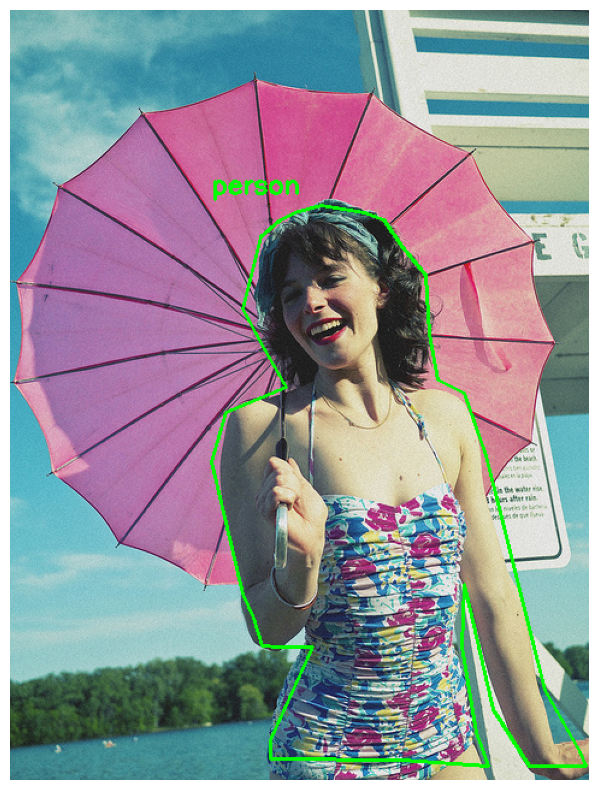

In [95]:
display_image1("/content/COCOdataset2017/images/train/person/000000000036.jpg")

# Dataset Preparation

Function : Create Df from a directory ( Will be used to create dfs for train, valid and test directories)

In [97]:
import pandas as pd

def create_df(folder_path):
    data = []
    category_names = ["cake","car","dog","person"]
    for category_name in category_names:
        subfolder_path = os.path.join(folder_path, category_name)

        if not os.path.exists(subfolder_path):
            print(f"Subfolder for {category_name} does not exist.")
            continue

        for image_file in os.listdir(subfolder_path):
            if image_file.endswith(('.jpg', '.jpeg', '.png')):
                im_path = os.path.join(subfolder_path, image_file)
                img_id = int(image_file.split('.')[0])
                catIds = coco.getCatIds(catNms=[category_name])
                annIds = coco.getAnnIds(imgIds=img_id, catIds=catIds, iscrowd=None)
                anns = coco.loadAnns(annIds)

                segmentations = [ann['segmentation'] for ann in anns]
                data.append([im_path, category_name, segmentations])

    df = pd.DataFrame(data, columns=['Image Path', 'Class Name', 'Segmentations'])
    return df

In [98]:
train_df=create_df("/content/COCOdataset2017/images/train")

In [100]:
train_df.head()

,Image Path,Class Name,Segmentations
0,/content/COCOdataset2017/images/train/cake/000...,cake,"[[[310.54, 205.84, 306.41, 263.6, 313.29, 299...."
1,/content/COCOdataset2017/images/train/cake/000...,cake,"[[[254.94, 278.62, 319.12, 282.05, 359.78, 280..."
2,/content/COCOdataset2017/images/train/cake/000...,cake,"[[[448.86, 16.21, 525.1, 54.87, 554.09, 77.42,..."
3,/content/COCOdataset2017/images/train/cake/000...,cake,"[[[638.1, 347.36, 513.36, 335.84, 522.0, 307.0..."
4,/content/COCOdataset2017/images/train/cake/000...,cake,"[[[137.42, 424.52, 110.93, 393.21, 100.82, 381..."


Function : This function Preprocesses image to be passed to our Model

In [134]:
def preprocess_image(image_path, target_size=(224, 224)):
    """
    Preprocess an image: resize maintaining aspect ratio, pad to target size,
    and apply mean pixel subtraction.

    Parameters:
    - image_path: str, path to the image file.
    - target_size: tuple (width, height), the target image size.

    Returns:
    - preprocessed_image: numpy array, the preprocessed image data.
    """
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Calculate scale to resize the image
    (height, width, _) = image.shape
    scale = min(target_size[0] / width, target_size[1] / height)
    new_width, new_height = int(width * scale), int(height * scale)

    # Resize the image with calculated scale
    image_resized = cv2.resize(image, (new_width, new_height))

    # Prepare an empty canvas with the target size
    padded_image = np.zeros((target_size[1], target_size[0], 3), dtype=np.uint8)

    # Calculate padding offsets
    y_offset = (target_size[1] - new_height) // 2
    x_offset = (target_size[0] - new_width) // 2

    # Place the resized image onto the center of the canvas
    padded_image[y_offset:y_offset+new_height, x_offset:x_offset+new_width, :] = image_resized

    # Apply mean pixel subtraction (using ImageNet mean for RGB channels)
    mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)  # RGB order
    preprocessed_image = padded_image.astype(np.float32)
    preprocessed_image -= mean

    return preprocessed_image


In [133]:
preprocess_image("/content/COCOdataset2017/images/train/person/000000000036.jpg").shape

(224, 168, 3)

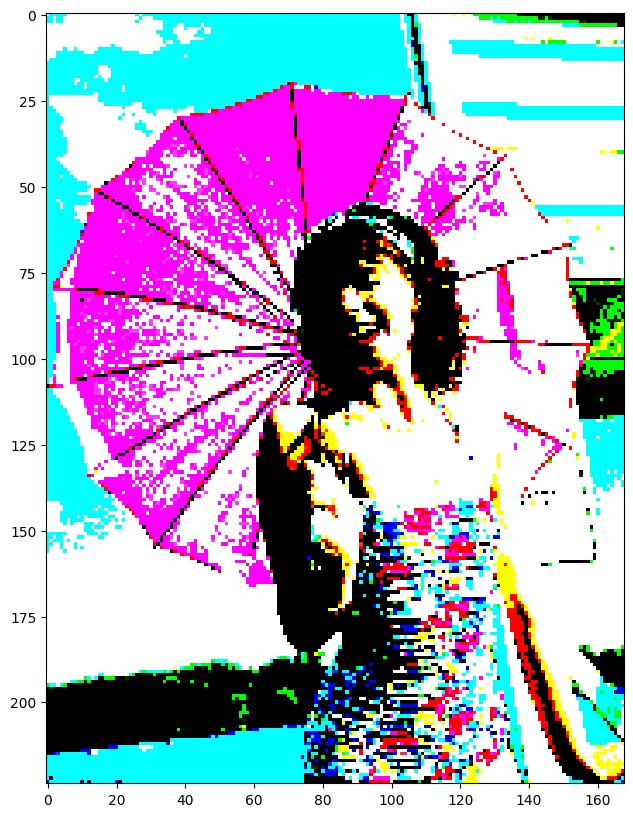

In [108]:
plt.imshow(preprocess_image("/content/COCOdataset2017/images/train/person/000000000036.jpg"))

Building Model Architecture

In [ ]:
"""
The model architecture leverages skip connections to fuse features from different layers of the encoder with the decoder,
enhancing the model's ability to capture fine details in the segmentation maps. The decoder comprises upsampling layers
and convolutional layers to progressively reconstruct the segmentation mask from the encoded features.
The final layer uses a convolutional layer with a sigmoid or softmax activation function to output the segmentation mask,
depending on whether you're doing binary segmentation or multi-class segmentation, respectively.
"""

import tensorflow as tf
from tensorflow.keras import layers, models


encoder = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_tensor=tf.keras.Input(shape=(224, 224, 3)))
encoder.trainable = False

x = encoder.output
x = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
x = layers.concatenate([x, encoder.get_layer('conv4_block6_out').output])
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2DTranspose(128, kernel_size=(3, 3), strides=(2, 2), padding='same')(x)
x = layers.Conv2DTranspose(64, kernel_size=(3, 3), strides=(2, 2), padding='same')(x)


output = layers.Conv2D(1, (1, 1), activation='sigmoid')(x)


model = models.Model(inputs=encoder.input, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Function : To convert polygon segmentations into binary masks

In [147]:
import tensorflow as tf
from pycocotools.mask import frPyObjects, decode
from skimage.transform import resize

def polygons_to_mask(target_size, polygons):
    # Initialize a mask array at the target size with a single channel, filled with zeros
    mask = np.zeros((target_size[0], target_size[1], 1), dtype=np.float32)

    for polygon in polygons:
        # Assume polygon is in the format compatible with frPyObjects and decode
        rle = frPyObjects(polygon, target_size[0], target_size[1])
        m = decode(rle)

        # If the mask isn't already at the target size, resize it
        if m.shape != mask.shape:
            m = resize(m, (target_size[0], target_size[1]), preserve_range=True, anti_aliasing=True)
            m = np.expand_dims(m, axis=-1)  # Ensure m has a single channel

        # Combine the current mask with the new mask
        mask = np.maximum(mask, m.astype(np.float32))

    return mask


Class Data Generators

In [140]:
class SegmentationDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, dataframe, preprocess_image, batch_size=32,target_size=(224, 224)):
        self.dataframe = dataframe
        self.batch_size = batch_size
        self.preprocess_func = preprocess_image
        self.target_size=target_size

    def __len__(self):
        return len(self.dataframe) // self.batch_size

    def __getitem__(self, idx):
        batch_data = self.dataframe.iloc[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_images = []
        batch_masks = []
        for _, row in batch_data.iterrows():
            img_path = row['Image Path']
            img = self.preprocess_func(img_path)
            batch_images.append(img)

            segmentation = row['Segmentations']
            mask = polygons_to_mask(self.target_size, segmentation)
            mask = np.expand_dims(mask, -1)
            batch_masks.append(mask)

        return np.array(batch_images), np.array(batch_masks)


In [ ]:
train_generator = SegmentationDataGenerator(train_df,preprocess_image, batch_size=16)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(train_generator, epochs=10)
